# 1.&nbsp;Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
import os
import warnings
import random
import csv
import time
# import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
import sklearn
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
import keras
import keras.backend as K
from keras import regularizers
from keras.callbacks import Callback
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Conv1D, MaxPooling1D, Lambda, Input, Embedding, Flatten, Activation, RepeatVector, Permute, Concatenate
from keras.models import Sequential, Model
import torch
import pickle
import joblib
import marshal

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
# np.random.seed(1337)

In [ ]:
print('Version informations:')
print(f'Python: {sys.version}')
print(f'Scikit learn: {sklearn.__version__}')
print(f'Numpy: {np.__version__}')
print(f'Keras: {keras.__version__}')

Version informations:
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Scikit learn: 1.2.2
Numpy: 1.25.2
Keras: 2.15.0


#2.&nbsp;Utilities

In [ ]:
# X: np.array, Y: Python list

def read_from_pt(embedding_path, label_path):
  embeddings = torch.load(embedding_path, map_location=torch.device('cpu'))
  labels = torch.load(label_path, map_location=torch.device('cpu'))
  X, Y = [], []
  for i in range(embeddings.shape[0]):
    if i == 0:
      print(embeddings[i])
    X.append(embeddings[i].numpy())
    Y.append(str(labels[i].tolist()))
  return np.array(X), Y

def read_from_csv(csv_path):
  data = pd.read_csv(csv_path)
  X = np.array([eval(x) for x in data['vector'].values])
  Y = [str(x) for x in data['label'].values]
  return X, Y


def save_to_pt(X, Y, pt_path):
  raise NotImplementedError('This method has not been implemented yet.')

def read_vector_from_csv(csv_path):
  X, Y = [], []
  with open(csv_path, "r") as file:
    reader = csv.reader(file)
    for row in reader:
      x = list([float(x) for x in row])
      Y.append(x.pop())
      X.append(x)
  return np.array(X), Y

def save_to_csv(X, Y, csv_path):
  X = X.to_list()
  Y = Y.to_list()
  with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['vector', 'label'])
    for i in range(len(X)):
      writer.writerow([X[i], Y[i]])
  return

def to_label_indexes(Y):
  index = {}
  newY = []
  for x in Y:
    if x not in index:
      index[x] = len(index)
    newY.append(index[x])
  return np.array(newY)

In [ ]:
def show_frequency_stat(Y, title=None):
  labels, counts = np.unique(Y, return_counts=True)
  if len(labels) == 0:
    print('Empty dataset.')
    return
  print(f'{len(Y)} vectors, {len(labels)} labels.')
  plt.bar(labels, counts)
  plt.xlabel('Labels')
  plt.ylabel('Counts')
  if title is None:
    plt.title('Number of Vectors per Label')
  else:
    plt.title(title)
  plt.show()
  for label, count in zip(labels, counts):
      print(f'Label {label}: {count} vectors.')
  return


In [ ]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
# no_colors = 10
# colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(no_colors)]
# All lines must have the same plot length
def plot_line_graphs(title, xlabel, ylabel, lines, curve_label):
    if len(lines) == 0:
      print('No line to be plotted.')
      return
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    X = [i for i in range(len(lines[0]))]
    for i in range(len(lines)):
      plt.plot(X, lines[i], label=curve_label[i], linestyle="solid", linewidth = '1', color=colors[i%len(colors)])
    plt.legend()
    plt.show()

In [ ]:
def weight_classes(Y):
  weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y), y=Y)
  return dict(zip(np.unique(Y), weights))

def weighted_f1_score(scores, weights):
  sum = 0
  total = 0
  for i in range(len(scores)):
    sum += weights[i]
    total += scores[i]*weights[i]
  return total/sum

In [ ]:
def sklearn_model_stat(X_test, Y_test, model, history=None, stat=False):
  Y_pred = model.predict(X_test)
  if history is not None:
    plot_line_graphs('', 'Epoch', 'Loss', [history['loss'], history['val_loss']], ['Train loss', 'Validation loss'])
  if stat:
    show_frequency_stat(Y_pred, 'Frequency of predicted labels.')
  recall_scores = recall_score(Y_pred, Y_test, average=None)
  precision_scores = precision_score(Y_pred, Y_test, average=None)
  scores = [2*recall_scores[i]*precision_scores[i]/(recall_scores[i]+precision_scores[i]) for i in range(len(recall_scores))]
  [print(f'Class index {i}: {recall_scores[i]:.3f}r - {precision_scores[i]:.3f}p - {scores[i]:.3f}f') for i in range(len(scores))]
  print(f'Weighted f1 score: {weighted_f1_score(scores, weight_classes(Y_test)):.3f}')
  print(f'Accuracy: {accuracy_score(Y_pred, Y_test):.3f}')

In [ ]:
def keras_model_stat(X_test, Y_test, model, stat=False): # LSTM and BiLSTM
  try:
    _, token_size, vector_size = model.layers[0].input_shape
    reshape = True
  except:
    try:
      _, token_size, vector_size = model.layers[0].input_shape[0]
      reshape = True
    except:
      reshape = False
  if reshape:
    X_test = np.reshape(X_test, (X_test.shape[0], token_size, vector_size))
  Y_pred = np.argmax(model.predict(X_test, verbose=0), axis=-1)
  if stat:
    show_frequency_stat(Y_pred, 'Frequency of predicted labels.')
  recall_scores = recall_score(Y_pred, Y_test, average=None)
  precision_scores = precision_score(Y_pred, Y_test, average=None)
  scores = [2*recall_scores[i]*precision_scores[i]/(recall_scores[i]+precision_scores[i]) for i in range(len(recall_scores))]
  [print(f'Class index {i}: {recall_scores[i]:.3f}r - {precision_scores[i]:.3f}p - {scores[i]:.3f}f') for i in range(len(scores))]
  print(f'Weighted f1 score: {weighted_f1_score(scores, weight_classes(Y_test)):.3f}')
  print(f'Accuracy: {accuracy_score(Y_pred, Y_test):.3f}')

In [ ]:
def get_latex_table(X, Y, w_model):
  Y_pred = w_model.interview(X)
  n_class = len(set(Y))
  recall_scores = recall_score(Y_pred, Y, average=None)
  precision_scores = precision_score(Y_pred, Y, average=None)
  scores = [2*recall_scores[i]*precision_scores[i]/(recall_scores[i]+precision_scores[i]) for i in range(len(recall_scores))]
  for i in range(n_class):
    print(f'{i + 1} & {recall_scores[i]:.3f} & {precision_scores[i]:.3f} & {scores[i]:.3f}\\\\')
  print(f'Average f1 score: {weighted_f1_score(scores, weight_classes(Y)):.3f}')
  print(f'Accuracy: {accuracy_score(Y_pred, Y):.3f}')

In [ ]:
def sklearn_model_acc(X_test, Y_test, model):
  return accuracy_score(model.predict(X_test), Y_test)

In [ ]:
class AdamCallBack(Callback):
  def __init__(self, safe_epoch=100, low_val_acc=0.1, high_val_acc=0.999, high_val_loss=10.0, verbose=1, val_set=False):
    self.verbose = verbose
    self.start_time = time.perf_counter()
    self.val_set = val_set
    self.safe_epoch = safe_epoch
    self.low_val_acc = low_val_acc
    self.high_val_acc = high_val_acc
    self.high_val_loss = high_val_loss

  def on_epoch_end(self, epoch, logs={}):
    if self.verbose > 0 and self.val_set:
      print(f'epoch, loss, acc, val_loss, val_acc: {epoch + 1}, {logs["loss"]:.3f}, {logs["accuracy"]:.3f}, {logs["val_loss"]:.3f}, {logs["val_accuracy"]:.3f} {(time.perf_counter() - self.start_time):.1f}(s).')
    elif self.verbose > 0:
      print(f'epoch, loss, acc: {epoch + 1}, {logs["loss"]:.3f}, {logs["accuracy"]:.3f} {(time.perf_counter() - self.start_time):.1f}(s).')
    if epoch >= self.safe_epoch - 1 and self.val_set and (logs['val_accuracy'] >= self.high_val_acc or logs['val_accuracy'] <= self.low_val_acc or logs['val_loss'] >= self.high_val_loss):
        self.model.stop_training = True
    return

  def on_batch_end(self, epoch, logs={}):
    if self.verbose > 1:
      print(f'Another batch finshed in {(time.perf_counter() - self.start_time):.1s}.')
    return

In [ ]:
def keras_model_acc(X_test, Y_test, model):
  try:
    _, token_size, vector_size = model.layers[0].input_shape
    X_test = np.reshape(X_test, (X_test.shape[0], token_size, vector_size))
  except:
    pass
  Y_pred = np.argmax(model.predict(X_test, verbose=0), axis=-1)
  return accuracy_score(Y_pred, Y_test)

# 3.&nbsp;Isolation Forest

Note: Remove outliers from the training set, do not drop outliers in the test set.

In [ ]:
# Especially good for SVM and SR.
def get_outlier_indices(X, con_rate='auto'):
  isolation_forest = IsolationForest(random_state = 100, contamination=con_rate)
  return isolation_forest.fit_predict(X)

def get_forest(X, con_rate='auto'):
  isolation_forest = IsolationForest(random_state = 100, contamination=con_rate)
  isolation_forest.fit(X)
  return isolation_forest

# 4.&nbsp;KMeans

In [ ]:
def b_cubed_precision(cdict, ldict):
  n = len(cdict)
  nu_lst = [len([j for j in range(n) if j != i and ldict[j] == ldict[i] and cdict[j] == cdict[i]]) for i in range(n)]
  de_lst = [len([j for j in range(n) if cdict[j] == cdict[i] and j != i]) for i in range(n)]
  return np.mean([nu_lst[i]/de_lst[i] for i in range(n)])

def b_cubed_recall(cdict, ldict):
  n = len(cdict)
  nu_lst = [len([j for j in range(n) if j != i and ldict[j] == ldict[i] and cdict[j] == cdict[i]]) for i in range(n)]
  de_lst = [len([j for j in range(n) if ldict[j] == ldict[i] and j != i]) for i in range(n)]
  return np.mean([nu_lst[i]/de_lst[i] for i in range(n)])

def std_b_cubed(title, cdict, ldict):
  try:
    precision = b_cubed_precision(cdict, ldict)
    recall = b_cubed_recall(cdict, ldict)
    print("{} precision={:.2f}, recall={:.2f}".format(title, precision, recall))
  except ZeroDivisionError: # Only if there is a label associated with a single vector.
    print("Error: Division by zero occurred.")

In [ ]:
def visualize_sil_coef(vectors, kmeans):
  if not isinstance(vectors, np.ndarray):
    vectors = np.array(vectors)
  visualizer = SilhouetteVisualizer(kmeans)
  visualizer.fit(vectors)
  visualizer.show()

In [ ]:
def cluster(vectors, n_clusters, l2_prep = False, verbose=0):
  if not isinstance(vectors, np.ndarray):
    vectors = np.array(vectors)
  if l2_prep:
    vectors = preprocessing.normalize(vectors, norm='l2')
  kmeans = KMeans(n_clusters=n_clusters, random_state=100).fit(vectors)
  sil_avg = silhouette_score(vectors, kmeans.labels_)
  sil_values = silhouette_samples(vectors, kmeans.labels_)
  if verbose >= 2:
    print(f'Average silhouette score for each cluster:')
    for i in range(n_clusters):
      print(f'Cluster {i}: {np.mean([sil_values[kmeans.labels_ == i]])}')
  if verbose >= 1:
    print(f'Average silhouette score: {sil_avg}')
  return kmeans

# 5.&nbsp;SVM Classifier

In [ ]:
def support_vector_classify(train_set, kernel='rbf', class_balance=None, gamma='scale', C=1.0, random_state=100):
  X, Y = train_set
  svc = SVC(kernel=kernel, class_weight=class_balance, random_state=random_state, gamma=gamma, C=C)
  svc.fit(X, Y)
  return svc

# 6.&nbsp;Softmax Classifier

In [ ]:
def distribute_in_batches(X, Y, batch_size):
    num_batches = int(len(X)/batch_size)
    batches = []
    for i in range(num_batches):
        batch = (X[i*batch_size: (i+1)*batch_size], Y[i*batch_size: (i+1)*batch_size])
        batches.append(batch)
    return batches

In [ ]:
# class_balance is None or 'balanced'
def SGD_softmax_classify(train_set, val_set, n_epoch=10, batch_size=1024, verbose=1, \
                         alpha=1e-4, l1_ratio=0.15, max_iter=1000, learning_rate='optimal',
                         eta0=0.1, power_t=0.5, class_balance=None, random_state=100):
  start_time = time.perf_counter()
  X_train, Y_train = train_set
  X_val, Y_val = val_set
  batches = distribute_in_batches(X_train, Y_train, batch_size)
  lgreg = SGDClassifier(loss='log_loss', penalty='elasticnet', verbose=0, n_jobs=-1, \
                        alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, learning_rate=learning_rate, \
                        eta0=eta0, power_t=power_t, class_weight=class_balance, random_state=random_state)
  train_loss_lst, val_loss_lst = [], []
  for i in range(n_epoch):
    for (tX, tY) in batches:
      lgreg.partial_fit(tX, tY, classes=Y_train)
      if verbose > 1:
        print(f'Another batch finished in {(time.perf_counter() - start_time):.1f} (s).')
    if verbose >= 0:
      train_loss = log_loss(Y_train, lgreg.predict_proba(X_train))
      val_loss = log_loss(Y_val, lgreg.predict_proba(X_val))
      train_loss_lst.append(train_loss)
      val_loss_lst.append(val_loss)
      if verbose > 0:
        print(f'epoch, loss, val_loss: {i + 1}, {train_loss:.3}, {val_loss:.3}. Finished in {(time.perf_counter() - start_time):.1f} (s).')
  history = {"loss": train_loss_lst, "val_loss": val_loss_lst}
  return lgreg, history

In [ ]:
# class_balance is None or 'balanced'
def softmax_classify(train_set, val_set, class_balance=None, max_iter=100, C=1.0, l1_ratio=0.5):
  X_train, Y_train = train_set
  X_val, Y_val = val_set
  lgreg = LogisticRegression(multi_class="multinomial", solver="saga", penalty="elasticnet", verbose=0, random_state=100, n_jobs=-1, max_iter=max_iter, C=C, l1_ratio=l1_ratio)
  lgreg.fit(X_train, Y_train)
  return lgreg

# 7.&nbsp;Perceptron Classifier

In [ ]:
def weight_classes(Y):
  weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y), y=Y)
  return dict(zip(np.unique(Y), weights))

In [ ]:
def double_layer_perceptron_classify(train_set, val_set=None, units=96, drop=0.0, l1=[0.0, 0.0], l2=[0.0, 0.0], n_epoch=100, batch_size=64, callback=None):
  X_train, Y_train = train_set
  weight_dict = weight_classes(Y_train)
  n_class = len(set(Y_train))
  Y_train = np.eye(n_class)[Y_train]
  if val_set is not None:
    X_val, Y_val = val_set
    Y_val = np.eye(n_class)[Y_val]
    val_set = (X_val, Y_val)
  model = Sequential()
  model.add(Dense(units=units,
                  activation='relu',
                  kernel_regularizer=regularizers.L1L2(l1=l1[0], l2=l2[0]),
                  bias_regularizer=regularizers.L1L2(l1=l1[0], l2=l2[0])))
  if(drop > 0):
    model.add(Dropout(drop))
  model.add(Dense(units=n_class,
                  activation='softmax',
                  kernel_regularizer=regularizers.L1L2(l1=l1[1], l2=l2[1]),
                  bias_regularizer=regularizers.L1L2(l1=l1[1], l2=l2[1])))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(X_train, Y_train, validation_data=val_set, verbose=0, shuffle=False, callbacks=callback, \
                      class_weight=weight_dict, epochs=n_epoch, batch_size=batch_size)
  return model, history.history


# 8.&nbsp;LSTM

In [ ]:
# https://keras.io/api/layers/recurrent_layers/lstm/
# https://keras.io/api/models/model_training_apis/
# Layers input-output shape of form tf vector.
# Decrease no of LSTM cells by increase token_size

In [ ]:
def weight_classes(Y):
  weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
  return dict(zip(np.unique(Y_train), weights))

In [ ]:
def BiLSTM_classify(train_set, val_set=None, token_size=1, output_dim=64, drop=0.0, LSTM_drop=0.0, LSTM_redrop=0.0, l12=[0.0, 0.0], n_epoch=100, batch_size=64, callback=None):
  X_train, Y_train = train_set
  weight_dict = weight_classes(Y_train)
  n_class = len(set(Y_train))
  #print(X_train.shape[0], X_train.shape[1])
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]//token_size, token_size))
  Y_train = np.eye(n_class)[Y_train]
  if val_set is not None:
    X_val, Y_val = val_set
    X_val = np.reshape(X_val, (X_val.shape[0],  X_val.shape[1]//token_size, token_size))
    Y_val = np.eye(n_class)[Y_val]
    val_set = (X_val, Y_val)
  model = Sequential()
  #model.add(Conv1D(filters=256, kernel_size=2, padding='same', activation='sigmoid'))
  #model.add(MaxPooling1D(pool_size=2))
  #model.add(Dense(64, activation='relu'))
  #if(drop > 0):
    #model.add(Dropout(drop))
  #model.add(Bidirectional(LSTM(units=output_dim, dropout=LSTM_drop, recurrent_dropout=LSTM_redrop)))
  model.add(LSTM(units=output_dim, dropout=LSTM_drop, recurrent_dropout=LSTM_redrop))
  if(drop > 0):
    model.add(Dropout(drop))
  model.add(Dense(units=n_class,
                  activation='softmax',
                  kernel_regularizer=regularizers.L1L2(l1=l12[0], l2=l12[1]),
                  bias_regularizer=regularizers.L1L2(l1=l12[0], l2=l12[1])))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(X_train, Y_train, validation_data=val_set, verbose=0, shuffle=False, callbacks=callback, \
                      class_weight=weight_dict, epochs=n_epoch, batch_size=batch_size)
  return model, history.history

#9.&nbsp; Inference models

In [ ]:
# Simple model wrappers
class ClassicalModel:
  def __init__(self):
    self.model = None

  def set(self, model):
    self.model = model

  def get(self):
    return self.model

  def load(self, path):
    with open(path, 'rb') as file:
      self.model = pickle.load(file)

  def inference(self, x):
    return (self.model).predict([x])[0]

  def interview(self, X):
    return (self.model).predict(X)

  def predict_proba(self, X):
    return self.model.predict_proba(X)


class LSTMModel:
  def __init__(self):
    self.model, self.vector_size, self.token_size = None, None, None

  def set(self, model):
    try:
      _, self.vector_size, self.token_size = model.layers[0].input_shape
    except:
      try:
        _, self.vector_size, self.token_size = model.layers[0].input_shape[0]
      except:
        raise ValueError('Model was not recognized.')
    self.model = model

  def get(self):
    return self.model

  def load(self, path):
    self.model = keras.saving.load_model(path, safe_mode=False)
    try:
      _, self.vector_size, self.token_size = self.model.layers[0].input_shape
    except:
      try:
        _, self.vector_size, self.token_size = self.model.layers[0].input_shape[0]
      except:
        raise ValueError('Model was not recognized.')

  def inference(self, x):
    x = np.reshape([x], (1, self.vector_size, self.token_size))
    return np.argmax(self.model.predict(x, verbose=0), axis=-1)[0]

  def interview(self, X):
    if not isinstance(X, np.ndarray):
      X = np.array(X)
    X = np.reshape(X, (X.shape[0], self.vector_size, self.token_size))
    return np.argmax(self.model.predict(X, verbose=0), axis=-1)

  def predict_proba(self, X):
    if not isinstance(X, np.ndarray):
      X = np.array(X)
    X = np.reshape(X, (X.shape[0], self.vector_size, self.token_size))
    return self.model.predict(X, verbose=0)


class PerceptronModel:
  def __init__(self):
    self.model = None

  def set(self, model):
    self.model = model

  def get(self):
    return self.model

  def load(self, path):
    self.model = keras.saving.load_model(path, safe_mode=False)

  def inference(self, x):
    return np.argmax(self.model.predict(np.array([x]), verbose=0), axis=-1)[0]

  def interview(self, X):
    if not isinstance(X, np.ndarray):
      X = np.array(X)
    return np.argmax(self.model.predict(X, verbose=0), axis=-1)

  def predict_proba(self, X):
    if not isinstance(X, np.ndarray):
      X = np.array(X)
    return self.model.predict(X, verbose=0)

# Each model "inference" method must return a non negative integer.
# The first model is the base model.
class BagOfModels:
  def __init__(self, models):
    self.models = models
    self.n_label = 100

  def inference(self, x):
    return interview(self, np.array([x]))[0]

  def interview(self, X):
    predictions = []
    for i in range(len(self.models)):
      predictions.append(self.models[i].interview(X))
    labels = []
    for i in range(len(X)):
      cnt = [0]*self.n_label
      for pred in predictions:
        cnt[pred[i]] += 1
      best_label = np.argmax(cnt)
      if cnt[predictions[0][i]] == cnt[best_label]:
        labels.append(predictions[0][i])
      else:
        labels.append(best_label)
    return labels

#10.&nbsp; MAIN WORKSPACE

The training process considers the test set as the validation set. The primary goal is to maximize both accuracy and the average F1 score on the test set.

**The more the test set is being evaluated, the more it becomes the validation set.**


##10.1.&nbsp; Dataset

In [ ]:
PT_DATASET_PATH = [r'/content/drive/MyDrive/Colab/Dataset/embedding.pt', r'/content/drive/MyDrive/Colab/Dataset/labels.pt']
DATASET_PATH = r'/content/drive/MyDrive/Colab/Dataset/utc_opinion_dataset.csv'
SVM_MODEL_PATH = '/content/drive/MyDrive/Colab/Model/utc_svm.pkl'
LGREG_MODEL_PATH = '/content/drive/MyDrive/Colab/Model/utc_lgreg.pkl'
PERCEPTRON_MODEL_PATH_1 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_1.keras'
PERCEPTRON_WEIGHT_PATH_1 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_1.h5'
PERCEPTRON_MODEL_PATH_2 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_2.keras'
PERCEPTRON_WEIGHT_PATH_2 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_2.h5'
LSTM_MODEL_PATH_1 = '/content/drive/MyDrive/Colab/Model/utc_lstm_1.keras'
LSTM_WEIGHT_PATH_1 = '/content/drive/MyDrive/Colab/Model/utc_lstm_1.h5'
LSTM_MODEL_PATH_2 = '/content/drive/MyDrive/Colab/Model/utc_lstm_2.keras'
LSTM_WEIGHT_PATH_2 = '/content/drive/MyDrive/Colab/Model/utc_lstm_2.h5'


PERCEPTRON_MODEL_PATH_3 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_3.keras'
PERCEPTRON_WEIGHT_PATH_3 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_3.h5'
PERCEPTRON_MODEL_PATH_4 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_4.keras'
PERCEPTRON_WEIGHT_PATH_4 = '/content/drive/MyDrive/Colab/Model/utc_perceptron_4.h5'

LSTM_MODEL_PATH_3 = '/content/drive/MyDrive/Colab/Model/utc_lstm_3.keras'
LSTM_WEIGHT_PATH_3 = '/content/drive/MyDrive/Colab/Model/utc_lstm_3.h5'
LSTM_MODEL_PATH_4 = '/content/drive/MyDrive/Colab/Model/utc_lstm_4.keras'
LSTM_WEIGHT_PATH_4 = '/content/drive/MyDrive/Colab/Model/utc_lstm_4.h5'

In [ ]:

X, Y = np.array([]), []
X_train, Y_train, X_test, Y_test, X_val, Y_val = [], [], [], [], [], []

def get_all_data():
  global X, Y, X_train, Y_train, X_test, Y_test, X_val, Y_val
  X, Y = read_vector_from_csv(DATASET_PATH)
  Y = to_label_indexes(Y)
  show_frequency_stat(Y)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=100)
  X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, stratify=Y_test, random_state=100)

def prune_outliers():
  global X, Y, X_train, Y_train, X_test, Y_test, X_val, Y_val
  arr = get_outlier_indices(X_train)
  X_new, Y_new = [], []
  for i in range(len(arr)):
    if arr[i] == 1:
      X_new.append(X_train[i])
      Y_new.append(Y_train[i])
  X_train = np.array(X_new)
  Y_train = Y_new
  show_frequency_stat(Y_train, 'Frequency of labels after removing outliers.')


##10.2.&nbsp; SVM training

In [ ]:
get_all_data()
prune_outliers()

In [ ]:
def bruteforce(): # Top 3 models with the highest accuracy.
  model_lst = [None, None, None]
  C_lst = [-1, -1, -1]
  acc_lst = [-1, -1, -1]
  C = 1
  while C <= 5:
    svc = support_vector_classify((X_train, Y_train), class_balance='balanced', C = C)
    acc = sklearn_model_acc(X_val, Y_val, svc)
    if acc > acc_lst[0]:
      acc_lst[2], C_lst[2], model_lst[2] = acc_lst[1], C_lst[1], model_lst[1]
      acc_lst[1], C_lst[1], model_lst[1] = acc_lst[0], C_lst[0], model_lst[0]
      acc_lst[0], C_lst[0], model_lst[0] = acc, C, svc
    elif acc > acc_lst[1]:
      acc_lst[2], C_lst[2], model_lst[2] = acc_lst[1], C_lst[1], model_lst[1]
      acc_lst[1], C_lst[1], model_lst[1] = acc, C, svc
    elif acc > acc_lst[2]:
      acc_lst[2], C_lst[2], model_lst[2] = acc, C, svc
    print(C, ' - ', acc)
    C += 0.5
  return model_lst, C_lst

model_lst, C_lst = bruteforce()
for i in range(0, 3):
  print(str(C_lst[i])+':')
  sklearn_model_stat(X_test, Y_test, model_lst[i])


In [ ]:
index = 0
with open(SVM_MODEL_PATH, 'wb') as file:
  pickle.dump(model_lst[index], file)

In [ ]:
del model_lst, C_lst

##10.2.&nbsp; SR training

In [ ]:
get_all_data()
prune_outliers()

LR using SGD and minibatch, with optimal learning rate.

In [ ]:
lgreg, history = SGD_softmax_classify((X_train, Y_train), (X_val, Y_val), n_epoch=180, batch_size=1024,
                                      alpha=2e-4, class_balance=weight_classes(Y_train))
sklearn_model_stat(X_test, Y_test, lgreg, history=history)

LR using solver SAGA (garbage).

In [ ]:
# Literal garbage.
lgreg = softmax_classify((X_train, Y_train), (X_test, Y_test), C = 20, class_balance='balanced', l1_ratio=0.15)
sklearn_model_stat(X_test, Y_test, lgreg)

In [ ]:
with open(LGREG_MODEL_PATH, 'wb') as file:
  pickle.dump(lgreg, file)

In [ ]:
del lgreg, history

##10.3.&nbsp; Multilayers Perceptron training

10080 vectors, 11 labels.


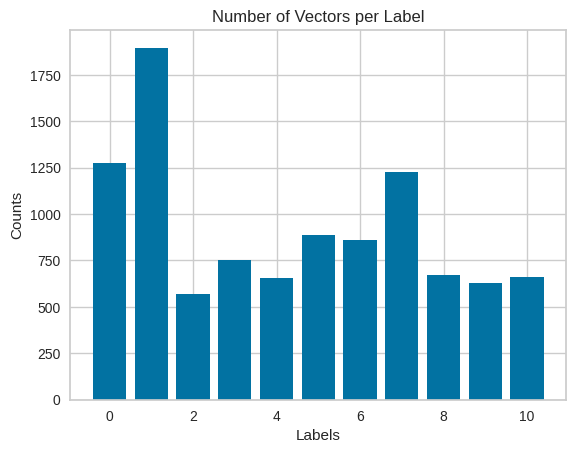

Label 0: 1274 vectors.
Label 1: 1896 vectors.
Label 2: 571 vectors.
Label 3: 754 vectors.
Label 4: 654 vectors.
Label 5: 886 vectors.
Label 6: 862 vectors.
Label 7: 1224 vectors.
Label 8: 672 vectors.
Label 9: 628 vectors.
Label 10: 659 vectors.


In [ ]:
get_all_data()

In [ ]:
callback = AdamCallBack(verbose=1, val_set=True, safe_epoch=50, low_val_acc=0.75, high_val_acc=0.828, high_val_loss=0.9)
perceptron, history = double_layer_perceptron_classify((X_train, Y_train), (X_val, Y_val), units=128, drop=0.6, n_epoch=400, batch_size=256, callback=callback)
perceptron.summary()
plot_line_graphs('Multilayers perceptron training result', 'Epoch', 'Loss', [history['loss'], history['val_loss']], ['Train loss', 'Validation loss'])
keras_model_stat(X_test, Y_test, perceptron)

In [ ]:
perceptron.save(PERCEPTRON_MODEL_PATH_1)
perceptron.save_weights(PERCEPTRON_WEIGHT_PATH_1)

In [ ]:
perceptron.save(PERCEPTRON_MODEL_PATH_2)
perceptron.save_weights(PERCEPTRON_WEIGHT_PATH_2)

In [ ]:
perceptron.save(PERCEPTRON_MODEL_PATH_3)
perceptron.save_weights(PERCEPTRON_WEIGHT_PATH_3)

In [ ]:
perceptron.save(PERCEPTRON_MODEL_PATH_4)
perceptron.save_weights(PERCEPTRON_WEIGHT_PATH_4)

In [ ]:
del perceptron, history

##10.4.&nbsp; LSTM training

10080 vectors, 11 labels.


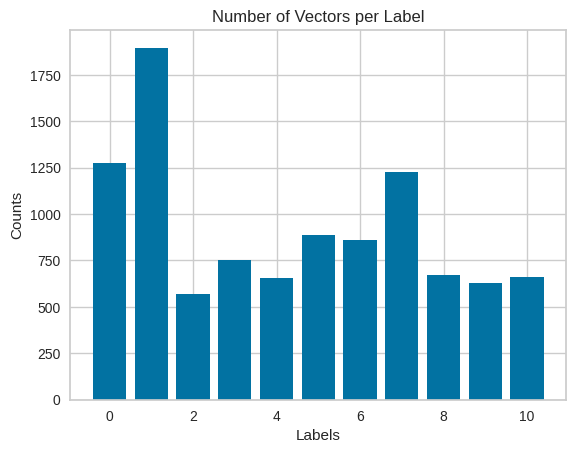

Label 0: 1274 vectors.
Label 1: 1896 vectors.
Label 2: 571 vectors.
Label 3: 754 vectors.
Label 4: 654 vectors.
Label 5: 886 vectors.
Label 6: 862 vectors.
Label 7: 1224 vectors.
Label 8: 672 vectors.
Label 9: 628 vectors.
Label 10: 659 vectors.


In [ ]:
get_all_data()
#prune_outliers()

In [ ]:
# Fail for average to small dataset.
callback = AdamCallBack(verbose=1, val_set=True, safe_epoch=50, low_val_acc=0.7, high_val_acc=0.822, high_val_loss=0.9)
bilstm, history = BiLSTM_classify((X_train, Y_train), (X_val, Y_val),\
                                   token_size=96, output_dim=32, drop=0.2, LSTM_drop=0.1,\
                                   n_epoch=600, batch_size=256, callback=callback)
bilstm.summary()
plot_line_graphs('BiLSTM training result', 'Epoch', 'Loss', [history['loss'], history['val_loss']], ['Train loss', 'Validation loss'])
keras_model_stat(X_test, Y_test, bilstm)

In [ ]:
def LSTM_ATT_classify():
  weight_dict = weight_classes(Y_train)
  lX_val = np.reshape(X_val, (X_val.shape[0], 8,  96)) # Token_size 96.
  lY_val = np.eye(11)[Y_val]
  lX_train = np.reshape(X_train, (X_train.shape[0], 8, 96))
  lY_train = np.eye(11)[Y_train]
  callback = AdamCallBack(verbose=1, val_set=True, safe_epoch=220, low_val_acc=0.7, high_val_acc=0.82, high_val_loss=0.9)
  input_seq = Input(shape=(8, 96))
  #activations = LSTM(units=64, return_sequences=True, dropout=0.2)(input_seq)
  activations = Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2))(input_seq)
  attention = Dense(1, activation='tanh')(activations)
  attention = Flatten()(attention)
  attention = Activation('softmax')(attention)
  attention = RepeatVector(64)(attention)
  attention = Permute([2, 1])(attention)
  sent_representation = Concatenate()([activations, attention])
  sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2))(sent_representation)
  sent_representation = Dropout(0.4)(sent_representation)
  probabilities = Dense(11, activation='softmax')(sent_representation)
  model = Model(inputs=input_seq, outputs=probabilities)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(lX_train, lY_train, validation_data=(lX_val, lY_val), epochs=400, batch_size=256, class_weight=weight_dict,verbose=0, callbacks=callback)
  return model, history.history

lstm, history = LSTM_ATT_classify()
lstm.summary()
plot_line_graphs('LSTM training result', 'Epoch', 'Loss', [history['loss'], history['val_loss']], ['Train loss', 'Validation loss'])
keras_model_stat(X_test, Y_test, lstm)

In [ ]:
lstm.save(LSTM_MODEL_PATH_1)
lstm.save_weights(LSTM_WEIGHT_PATH_1)

In [ ]:
lstm.save(LSTM_MODEL_PATH_2)
lstm.save_weights(LSTM_WEIGHT_PATH_2)

In [ ]:
lstm.save(LSTM_MODEL_PATH_3)
lstm.save_weights(LSTM_WEIGHT_PATH_3)

In [ ]:
lstm.save(LSTM_MODEL_PATH_4)
lstm.save_weights(LSTM_WEIGHT_PATH_4)

In [ ]:
del lstm, history

##10.5.&nbsp; Inference

In [ ]:
get_all_data()

print(weight_classes(Y))

In [ ]:
w_lgreg = ClassicalModel()
w_lgreg.load(LGREG_MODEL_PATH)

w_svc = ClassicalModel()
w_svc.load(SVM_MODEL_PATH)

w_perceptron_1 = PerceptronModel()
w_perceptron_1.load(PERCEPTRON_MODEL_PATH_1)

w_lstm_1 = LSTMModel()
w_lstm_1.load(LSTM_MODEL_PATH_1)

In [ ]:
w_lstm_2 = LSTMModel()
w_lstm_2.load(LSTM_MODEL_PATH_2)

w_lstm_3 = LSTMModel()
w_lstm_3.load(LSTM_MODEL_PATH_3)

w_lstm_4 = LSTMModel()
w_lstm_4.load(LSTM_MODEL_PATH_4)

w_perceptron_2 = PerceptronModel()
w_perceptron_2.load(PERCEPTRON_MODEL_PATH_2)

w_perceptron_3 = PerceptronModel()
w_perceptron_3.load(PERCEPTRON_MODEL_PATH_3)

w_perceptron_4 = PerceptronModel()
w_perceptron_4.load(PERCEPTRON_MODEL_PATH_4)

In [ ]:
bag = BagOfModels([w_lstm_3, w_svc, w_perceptron_4])
bag.n_label = 11
get_latex_table(X_test, Y_test, bag)

In [ ]:
get_latex_table(X_test, Y_test, w_lgreg)